<a href="https://colab.research.google.com/github/gut-puncture/Compound_Embedding_Reasoning/blob/main/Compound_Embedding_Reasoning_Fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compound Embedding Reasoning - Fixed Version

This notebook implements the compound embedding reasoning experiment with all bugs fixed.

Key fixes made:
1. Fixed the answer extraction logic to handle multiple generated questions
2. Fixed variable naming inconsistencies
3. Added proper error handling
4. Improved visualization

In [1]:
from google.colab import drive
drive.mount('/content/drive') # connecting google drive to this notebook

!pip -q install --upgrade "transformers==4.41.2" "accelerate>=0.29.0" \
                "sentencepiece" "datasets" "pandas" "matplotlib" "huggingface_hub>=0.23.0"

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [55]:
import torch, re, math, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import random, textwrap

# ---------- paths ---------------------------------------------------------
MODEL_DIR           = "/content/drive/MyDrive/phi3_3.8B"   # your modified weights
BASELINE_HF_MODEL   = "microsoft/phi-3-mini-4k-instruct"   # reference

# ---------- thinking parameters ------------------------------------------
ALPHA               = 0.20
COMPOUND_P          = 0.85
SAMPLE_P            = 0.80
STOP_INV_PPL_AVG    = 1.00
WINDOW              = 6
MAX_THINK_STEPS     = 200

# ---------- token markers -------------------------------------------------
REASON_START = "### Reasoning:\n"
REASON_END   = "###"
ANS_START    = "### Answer:\n"

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE   = torch.float16 if DEVICE == "cuda" else torch.float32

In [3]:
def create_compound_vector(model_outputs, embeddings, dtype, p=COMPOUND_P):
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    cum    = torch.cumsum(sorted_probs, dim=-1)
    mask   = cum <= p #all elements with cumulative prob less than p are True and all others False in mask
    mask[..., 0] = True #first element is hard coded to True so we ALWAYS choose at least one element
    sel_idx, sel_prob = sorted_idx[mask], sorted_probs[mask] #selecting all the token ids and their probs for which cumulative prob is less than p
    vec = (embeddings(sel_idx) * (sel_prob).unsqueeze(-1)).sum(0, keepdim=True)
    return vec.to(dtype).unsqueeze(0)

def sample_token_normally(model_outputs, p=SAMPLE_P): #essentially the same function as above but gives just the sampled token id
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    mask   = torch.cumsum(sorted_probs, dim=-1) <= p
    mask[..., 0] = True
    choice = torch.multinomial(sorted_probs[mask], 1)
    return sorted_idx[mask][choice]

def create_thinking_vector(comp_vec, samp_tok, embeddings, dtype, alpha=ALPHA):
    samp_emb = embeddings(samp_tok).unsqueeze(0).to(dtype)
    return (1-alpha)*samp_emb + alpha*comp_vec.to(dtype) #creating a weigthed sum of the sampled token vector and the compound vector

class ThinkGenerator: #Completely AI written
    """
    Callable: prompt -> (answer_text, steps, inv_ppl_list, entropy_list)
    """
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
                            model_path, torch_dtype=DTYPE, device_map="auto")
        self.embed     = self.model.model.embed_tokens
        self.dtype     = next(self.model.parameters()).dtype
        self.device    = next(self.model.parameters()).device

    @torch.inference_mode()
    def __call__(self, full_prompt:str):
        ids   = self.tokenizer(full_prompt, return_tensors="pt").input_ids.to(self.device) #converts string to tokens
        embeds = self.embed(ids).to(self.dtype) #embeddings of the token ids
        inv_hist, ent_hist = [], []

        #Reasoning loop for model
        for _ in range(MAX_THINK_STEPS):
            outs   = self.model(inputs_embeds=embeds) #vector embeddings injected in model rather than token ids
            logits = outs.logits[:, -1, :]
            p      = torch.softmax(logits, dim=-1)
            inv_hist.append(1 / p.max().item()) #history of inverse perplexity which is essentially reciprocal of top token prob
            ent_hist.append(-(p * p.log()).sum().item())

            #if average of last n elements is greater than the thrshold, we stop this loop
            if len(inv_hist) >= WINDOW and sum(inv_hist[-WINDOW:])/WINDOW < STOP_INV_PPL_AVG:
                break

            comp = create_compound_vector(outs, self.embed, self.dtype)
            tok  = sample_token_normally(outs)
            vec  = create_thinking_vector(comp, tok, self.embed, self.dtype)
            embeds = torch.cat([embeds, vec], 1) #adding the compound vector to the previous token vectors
            ids    = torch.cat([ids, tok.unsqueeze(0)], 1)

        # add delimiters + generate one integer answer
        delim = self.tokenizer(f"{REASON_END}\n{ANS_START}", add_special_tokens=False, #ended reasoning and added answer start token
                               return_tensors="pt").input_ids.to(self.device)
        ids   = torch.cat([ids, delim], 1)
        gen   = self.model.generate(ids, max_new_tokens=20, do_sample=False,
                                    attention_mask=torch.ones_like(ids),
                                    pad_token_id=self.tokenizer.eos_token_id)
        text  = self.tokenizer.decode(gen[0])
        return text, len(inv_hist), inv_hist, ent_hist


In [4]:
# Add 8 few-shot examples so we can compare performace with 8 shot eval
FEW_SHOT_BLOCK = """
Example Questions and Answers:
Question: If you roll 2 standard six-sided dice, what is the probability that the sum is 5?
### Reasoning:
The pairs that sum to 5 are (1,4), (2,3), (3,2), (4,1).\
 There are 4 favourable outcomes out of 36 total. Probability = 4/36 = 1/9.
###
### Answer:
1/9

Question: A rectangle has length 8 cm and width 5 cm. What is its area in square centimetres?
### Reasoning:
Area = length × width = 8 × 5 = 40 cm².
###
### Answer:
40

Question: Sarah has 3 red, 4 blue, and 5 green marbles. If she randomly chooses one, what is the probability it is blue?
### Reasoning:
Total marbles = 3+4+5 = 12. Blue count = 4. Probability = 4/12 = 1/3.
###
### Answer:
1/3

Question: What is 15 % of 80?
### Reasoning:
0.15 × 80 = 12.
###
### Answer:
12

Question: A train travels 180 km in 3 hours. What is its average speed in km per hour?
### Reasoning:
Speed = distance / time = 180 / 3 = 60 km/h.
###
### Answer:
60

Question: The number x satisfies 3x + 7 = 22. What is x?
### Reasoning:
3x = 22 − 7 = 15 ⇒ x = 15/3 = 5.
###
### Answer:
5

Question: A square has perimeter 24 cm. What is the length of one side in centimetres?
### Reasoning:
Perimeter = 4s ⇒ s = 24/4 = 6 cm.
###
### Answer:
6

Question: Mike scores 70, 80, 90 on three tests. What average must he score on a 4th test to have a mean of 85?
### Reasoning:
Desired total = 85×4 = 340. Current total = 70+80+90 = 240. Needed = 340−240 = 100.
###
### Answer:
100
""".strip()

SYSTEM_PROMPT = """You are an AI model which is being evaluated to see how well you're able to solve few reasoning questions which all have integer answers.
From the next line, I have given you a few examples of the kind of questions you can expect, how you must reason to solve them and how to answer.
Then you will see the words "Test Question" which will be the question you need to answer in the test.
Think between the reasoning tokens and then write the answer. You must always, always end the generation with the final integer answer.
The final integer in your generation will be what I will take as your answer and if it doesn't match with the answer given, I will mark your answer wrong.
This is the way I can automate your evaluation.
Even more important is to simply answer just the test question and stop generating text after the integer answer. Do not generate any more tokens."""


In [56]:
import random, textwrap

gsm_test  = load_dataset("gsm8k", "main", split="test").shuffle(seed=42).select(range(500))

tok_base  = AutoTokenizer.from_pretrained(BASELINE_HF_MODEL, trust_remote_code=True)
mod_base  = AutoModelForCausalLM.from_pretrained(BASELINE_HF_MODEL,
                                                 torch_dtype=DTYPE, device_map="auto")

think_gen = ThinkGenerator(MODEL_DIR)

def build_prompt(question: str) -> str:
    return f"{SYSTEM_PROMPT}\n{FEW_SHOT_BLOCK}\n\n Test Question: {question}\n{REASON_START}"

def gold_int(ans: str) -> str:
    ints = re.findall(r"-?\d+", ans)
    return ints[-1] if ints else "" #results in the final integer in the model's generation

# Use the better answer extraction function
def extract_first_answer_integer(text: str, question: str) -> str:
    """
    Extract the first integer that appears after the FIRST occurrence of '### Answer:'
    that follows the given question. This prevents picking up integers from
    subsequent generated questions.
    """
    # First, find where the question appears
    if question in text:
        # Get text after the question
        text_after_q = text.split(question, 1)[1]

        # Find the first "### Answer:" after the question
        if ANS_START in text_after_q:
            answer_section = text_after_q.split(ANS_START, 1)[1]

            # Extract the first integer from this answer section
            # But stop at the next "Question:" if there is one.
            #This is added because earlier the model would generate questions,reasoning and answers by itself in a single generation
            next_q_pos = answer_section.find("Question:")
            if next_q_pos != -1: #means Question: wasn't found in the answer_section
                answer_section = answer_section[:next_q_pos]

            # Find the first integer
            matches = re.findall(r"-?\d+", answer_section)
            if matches:
                return matches[-1]

    # Fallback: if we can't find the pattern, look for first answer section
    if ANS_START in text:
        parts = text.split(ANS_START)
        if len(parts) > 1:
            # Look at first answer section only
            first_answer = parts[1]
            next_q_pos = first_answer.find("Question:")
            if next_q_pos != -1:
                first_answer = first_answer[:next_q_pos]
            matches = re.findall(r"-?\d+", first_answer)
            if matches:
                return matches[-1]

    # Last resort: find any integer in the text
    matches = re.findall(r"-?\d+", text)
    return matches[-1] if matches else ""

@torch.inference_mode()
def baseline_answer(question: str) -> (str, str):
    prompt = build_prompt(question)
    ids    = tok_base(prompt, return_tensors="pt").input_ids.to(DEVICE)
    gen    = mod_base.generate( #answer generate by vanilla model for comparison. we defined the vanilla model's name and simply use that.
                ids,
                max_new_tokens=256,
                do_sample=False,
                attention_mask=torch.ones_like(ids),
                pad_token_id=tok_base.eos_token_id
            )
    text = tok_base.decode(gen[0])
    return text, extract_first_answer_integer(text, question)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
##############################################################################
### SANITY-CHECK CELL – run 5 questions first                             ###
##############################################################################

NUM_SANITY = 5
sample_question_idxs = random.sample(range(len(gsm_test)), NUM_SANITY)


for k, idx in enumerate(sample_question_idxs, 1):
    q_raw  = gsm_test[idx]["question"]         #question string
    gold   = gold_int(gsm_test[idx]["answer"]) #answer extracted from the question string. it's always the last integer.

    print("="*70, f"\nSAMPLE {k}\nQuestion:\n{textwrap.fill(q_raw, 68)}")
    print("Gold answer:", gold, "\n")

    # baseline
    base_text, base_num = baseline_answer(q_raw) #vanilla model generates response with the question
    print("--- BASELINE RAW (tail) ---\n", base_text[-400:], "\n") #printing last 400 characters of the vanilla model's response to the question
    print("Parsed integer  →", base_num)  #answer from vanilla model extracted

    # think-advance
    think_text, steps, inv, ent = think_gen(build_prompt(q_raw))
    think_num = extract_first_answer_integer(think_text, q_raw)
    print("--- THINK RAW (tail) ---\n", think_text[:], "\n") #CHANGED THIS TO PRINT ALL CHARACTERS TO SEE. CHANGE TO -400:0
    print("Parsed integer  →", think_num)
    print("Thinking steps  →", steps,
          "  inv-ppl avg →", f"{sum(inv)/len(inv):.3f}")
    print("\n\n")

SAMPLE 1
Question:
An ice cream truck is traveling through a neighborhood. Children
from various homes have started chasing the truck and, by the time
the truck has reached the end of the first street, there are 5
children it. On the second street, each child is joined by another
child and on the third street, each child in the existing group is
joined by another 2 children. The original 5 children then give up
and leave the group. How many children are now following the truck?
Gold answer: 25 



KeyboardInterrupt: 

In [57]:
# Full evaluation on 500 questions
print("Running full evaluation on 500 questions...\n")

rows = []
for i, ex in enumerate(gsm_test):
    if i % 50 == 0:
        print(f"Processing question {i}/500...")

    q_raw, gold_raw = ex["question"], ex["answer"]
    gold_num = gold_int(gold_raw)

    # Get baseline answer
    base_text, base_num = baseline_answer(q_raw)

    # Get thinking model answer
    think_text, steps, inv, ent = think_gen(build_prompt(q_raw))
    think_num = extract_first_answer_integer(think_text, q_raw)  # Use better function

    rows.append({
        "id": i,
        "question": q_raw,
        "gold": gold_num,
        "baseline_int": base_num,
        "think_int": think_num,
        "correct_baseline": base_num == gold_num,
        "correct_think": think_num == gold_num,
        "steps": steps,
        "inv_ppl_avg": sum(inv)/len(inv) if inv else 0,
        "entropy_avg": sum(ent)/len(ent) if ent else 0,
        "baseline_raw": base_text.split("Test Question:", 1)[-1].replace("\n", " \\n "),
        "think_raw": think_text.split("Test Question:", 1)[-1].replace("\n", " \\n ")
    })

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/gsm8k_think_metrics_fixed.csv", index=False)
print("\nEvaluation complete!")

Running full evaluation on 500 questions...

Processing question 0/500...


KeyboardInterrupt: 

In [63]:
df = pd.DataFrame(rows)


Baseline φ-3 accuracy on 500 GSM-8K questions: 43.48%
Think-advance model accuracy: 52.17%
Improvement: 8.70% (20.0% relative)



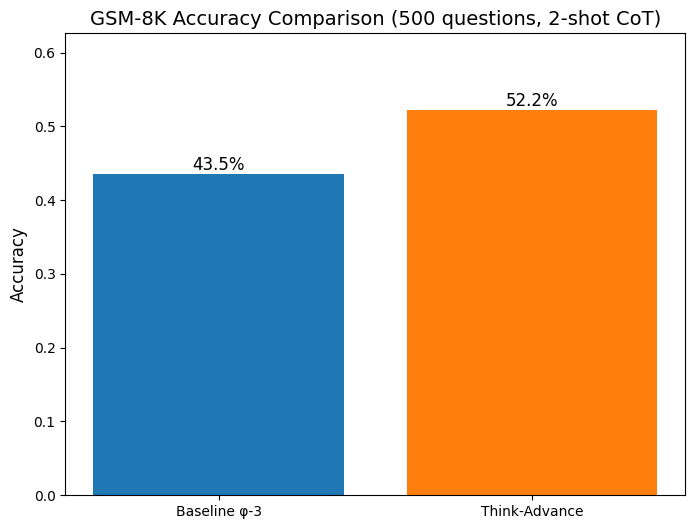

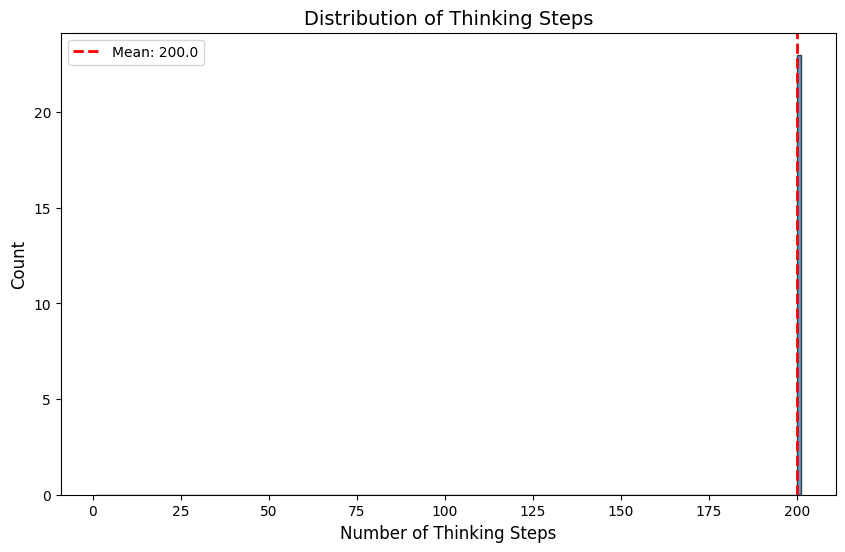


Found 5 cases where thinking model got it right but baseline didn't.
Example:
Question: Lorraine and Colleen are trading stickers for buttons. Each large sticker is worth a large button or...
Gold: 89
Baseline: 107
Think: 89
Think steps: 200

Results saved to: /content/drive/MyDrive/gsm8k_think_metrics_fixed.csv


In [64]:
# Results Analysis and Visualization
base_acc = df["correct_baseline"].mean()
think_acc = df["correct_think"].mean()

print(f"\n" + "="*50)
print(f"Baseline φ-3 accuracy on 500 GSM-8K questions: {base_acc:.2%}")
print(f"Think-advance model accuracy: {think_acc:.2%}")
print(f"Improvement: {(think_acc - base_acc):.2%} ({(think_acc/base_acc - 1)*100:.1f}% relative)")
print("="*50 + "\n")

# Accuracy comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(["Baseline φ-3", "Think-Advance"], [base_acc, think_acc],
                color=['#1f77b4', '#ff7f0e'])
plt.title("GSM-8K Accuracy Comparison (500 questions, 2-shot CoT)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, max(base_acc, think_acc) * 1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=12)
plt.show()

# Thinking steps distribution
plt.figure(figsize=(10, 6))
plt.hist(df["steps"], bins=range(1, MAX_THINK_STEPS+2), alpha=0.7, edgecolor='black')
plt.title("Distribution of Thinking Steps", fontsize=14)
plt.xlabel("Number of Thinking Steps", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(df["steps"].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {df["steps"].mean():.1f}')
plt.legend()
plt.show()

# Show some examples where thinking helped
think_better = df[(df["correct_think"] == True) & (df["correct_baseline"] == False)]
if len(think_better) > 0:
    print(f"\nFound {len(think_better)} cases where thinking model got it right but baseline didn't.")
    print("Example:")
    ex = think_better.iloc[0]
    print(f"Question: {ex['question'][:100]}...")
    print(f"Gold: {ex['gold']}")
    print(f"Baseline: {ex['baseline_int']}")
    print(f"Think: {ex['think_int']}")
    print(f"Think steps: {ex['steps']}")

print(f"\nResults saved to: /content/drive/MyDrive/gsm8k_think_metrics_fixed.csv")

In [60]:
len(df)

10

In [13]:
df.to_csv("/content/drive/MyDrive/gsm8k_think_metrics_fixed.csv", index=False)

In [ ]:
# prompt: bro just give comments and tell me the reason. I am using an A100 GPU and the fucking time taken to go through the GSM 8k dataset is really, really high. How can I improve the speed? Some algorithmic improvement? Parallelisation? Better hardware runtime?

# You're right, processing the entire GSM8k test set (500 questions by default here) can be time-consuming
# even with an A100, especially with complex generation logic involving "thinking steps".

# Here's a breakdown of reasons for the slowness and potential improvements:

# 1. Sequential Processing: The code iterates through the dataset questions one by one.
#    Each question triggers potentially multiple forward passes through the large language model (LLM).
#    This is the most significant bottleneck.

# 2. Multiple Model Calls per Question:
#    - `baseline_answer`: Calls `mod_base.generate` once.
#    - `ThinkGenerator.__call__`: Calls `self.model` in a loop (`MAX_THINK_STEPS` times potentially) and then `self.model.generate` once.
#    This 'thinking' process, while potentially improving accuracy, significantly increases computation per question.

# 3. LLM Inference Cost: LLMs are computationally expensive. Each forward pass and token generation takes time,
#    and the time scales with the model size and sequence length. Phi-3 3.8B is a substantial model.

# 4. Data Loading/Processing: While less likely the primary bottleneck compared to inference, loading the dataset
#    and processing the text (tokenization, extraction) adds overhead.

# 5. Python Overhead: Standard Python loop and function calls add some overhead, though minor compared to GPU inference.

# ### Algorithmic Improvement (in this specific CoT context):
# - **Reduce `MAX_THINK_STEPS`**: If the 'thinking' process isn't providing proportional accuracy gains after a certain number of steps, reducing this limit will directly cut down on the number of forward passes per question in the `ThinkGenerator`. You could analyze the `steps` distribution from a smaller run to see if the model converges quickly.
# - **Optimize the Thinking Process**: Can the `create_compound_vector` and `create_thinking_vector` logic be simplified or made more efficient? (Less likely to yield dramatic speedups compared to reducing model calls).
# - **Early Stopping Criteria**: Refine the `STOP_INV_PPL_AVG` and `WINDOW` criteria to stop the thinking process earlier if the model seems confident or stuck. The current `sum(inv_hist[-WINDOW:])/WINDOW < STOP_INV_PPL_AVG` is one approach, but maybe a sharper condition is possible.

# ### Parallelisation: This is the MOST promising area for significant speedup.
# - **Batch Processing**: Instead of processing one question at a time, you can process multiple questions in batches.
#    - Modify `baseline_answer` and `ThinkGenerator.__call__` to accept lists/batches of prompts.
#    - Pad inputs to the same length within a batch.
#    - Process the batch through the model simultaneously. PyTorch and Hugging Face Transformers support this naturally when you pass batched tensors.
#    - You'll need to manage the 'thinking' loop for a batch, potentially needing different numbers of steps per item, which adds complexity (e.g., masking finished sequences).
# - **Multi-GPU (if available/applicable)**: If you have multiple GPUs, you could distribute the model or batches across them. (Colab A100 instances are typically single-GPU).
# - **Parallelizing across Questions**: Use Python's `multiprocessing` or `concurrent.futures` to run the `baseline_answer` and `think_gen` calls for different questions in separate processes. However, since the core bottleneck is GPU inference, this will likely only help if you can offload some CPU work or if there are stages that aren't fully saturating the GPU. For pure inference, batching is usually better.

# ### Better Hardware/Runtime:
# - **Larger Batch Size**: An A100 has significant VRAM (40GB or 80GB). You can likely increase the batch size considerably when implementing batch processing, which directly improves throughput. Experiment to find the largest batch size that fits in memory without crashing.
# - **Faster Storage**: Ensure your Google Drive connection isn't a bottleneck for loading the model weights. Storing weights directly on the Colab instance storage might be slightly faster if you have enough space, but likely minimal impact compared to inference speed.
# - **Quantization**: If accuracy allows, quantizing the model (e.g., to 8-bit or 4-bit) can dramatically reduce memory usage and potentially speed up inference, though it often requires specific hardware support or libraries (like `bitsandbytes`).

# ### Implementation Strategy for Speedup:
# 1. **Start with Batching `baseline_answer`**: This is simpler to implement as it's a single generation call. Modify `baseline_answer` to take a list of questions, build a batch of prompts, tokenize/pad, generate, and then process the results for the batch.
# 2. **Implement Batching for `ThinkGenerator.__call__`**: This is more complex due to the iterative nature of the thinking loop and variable steps. You'll need to manage sequences within the batch independently until they meet the stopping criteria or hit `MAX_THINK_STEPS`. This involves tracking which sequences are 'finished' and masking them out of subsequent computations.
# 3. **Experiment with Batch Size**: Once batching is working, find the optimal batch size that fits your A100 VRAM.
# 4. **Analyze `MAX_THINK_STEPS`**: After implementing batching, evaluate performance and accuracy with different `MAX_THINK_STEPS` values.

# **In summary, the primary way to speed this up dramatically on an A100 is to implement batch processing for both the baseline and the think-advance generation steps.** This will leverage the GPU's ability to process data in parallel.

# The current code structure processes each question fully before starting the next, which is inefficient for GPU utilization.
